In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1'
trial_info_file = '/data/A2/converted/trialinfo_matrix_A2_cleanedtrials.mat'
data_file = '/data/A2/Experimental/data.mat'
epoch_file = '/epochs_from_matrix/epochs_2.fif'

relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import copy
from collections import Counter
from frequency_tagging_funs import snr_spectrum, frequency_rescaling, ssvep_amplitudes


In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']


# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif ...


/tmp/ipykernel_25340/719731429.py:23: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
467 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [4]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,467
Events,1: 467
Time range,-1.000 – 2.299 s
Baseline,off


In [5]:
# Keep only trials where there was no target
epochs = epochs['target_binary==0']

# Tag presence
## 1 FFT & SNR

In [6]:
epochs_freqtag = epochs['tagging_type==0'].copy()

# Simplify metadata
epochs_freqtag.metadata['flicker_sides'] = epochs_freqtag.metadata['flicker_sides'].replace({0: 6056, 1: 5660})
epochs_freqtag.metadata['cued_side'] = epochs_freqtag.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'left')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'right'))
condition_2 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'right')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'left'))
epochs_freqtag.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 56, np.nan))

/tmp/ipykernel_25340/4141921983.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


SNR at 56Hz: 5.618101101036192
SNR at 60Hz: 3.2200582904911417


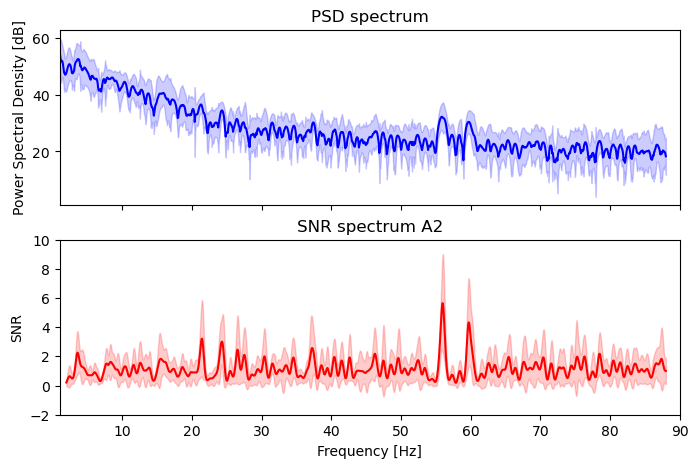

In [7]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

sfreq = epochs_freqtag.info["sfreq"]
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 1
fmin = 1.0
fmax = 90

# Spectrum of the signal averaged over trials
freqs_psd, psds = ssvep_amplitudes(epochs, epochs.info['ch_names'], tmin, tmax)

# Get bins to exlude from regularization (close neighbors ±0.5Hz)  
bin_size = np.diff(freqs_psd)[0]
skip_nei = int((0.5 - bin_size/2)//bin_size) 

# Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]

snrs = snr_spectrum(psds, noise_n_neighbor_freqs = used_nei, noise_skip_neighbor_freqs = skip_nei)


%matplotlib inline
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs_psd) == 1.0)[0][0], np.where(np.ceil(freqs_psd) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0))[freq_range]
snr_std = snrs.std(axis=(0))[freq_range]

axes[1].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum A2",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 10],
    xlim=[fmin, fmax],
)
fig.show()

# Extract SNR values at the stimulation frequency
stim_freq1 = 56
stim_freq2 = 60

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))

# Apply the subset
snrs_target1 = snrs[:, i_bin_1]
snrs_target2 = snrs[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz: {snrs_target1.mean()}')
print(f'SNR at {stim_freq2}Hz: {snrs_target2.mean()}')


## 2 Topography of the SNR

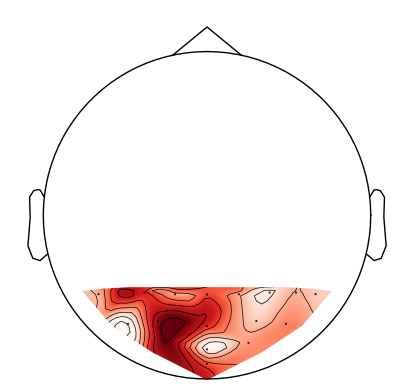

/tmp/ipykernel_25340/695356588.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


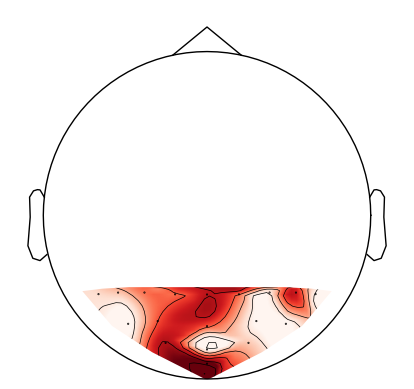

Channels with highest SNR for 56Hz['O1' 'PO3' 'P5' 'POz']
Channels with highest SNR for 60Hz['Iz' 'O1' 'Pz' 'P6']


/tmp/ipykernel_25340/695356588.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [8]:
# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target1, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target2, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()

# Channels with the highest SNR 
print(f'Channels with highest SNR for 56Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:4]}')
print(f'Channels with highest SNR for 60Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target2)[::-1]][:4]}')


#select electrodes from 56 as the top electrodes are parietal and occipital
SNR_best_electrodes_56 = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:4]
SNR_best_electrodes_60 = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2)[::-1]][:4]

## 3 Time frequency analysis of coherence by electrode
Coherence is studied in the time window between trial start and onset of the stimuli (the post stimuli window is likely contaminated by attentional catching due to their onset).

### Inter-trial coherence with Morlet estimation

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.0s


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


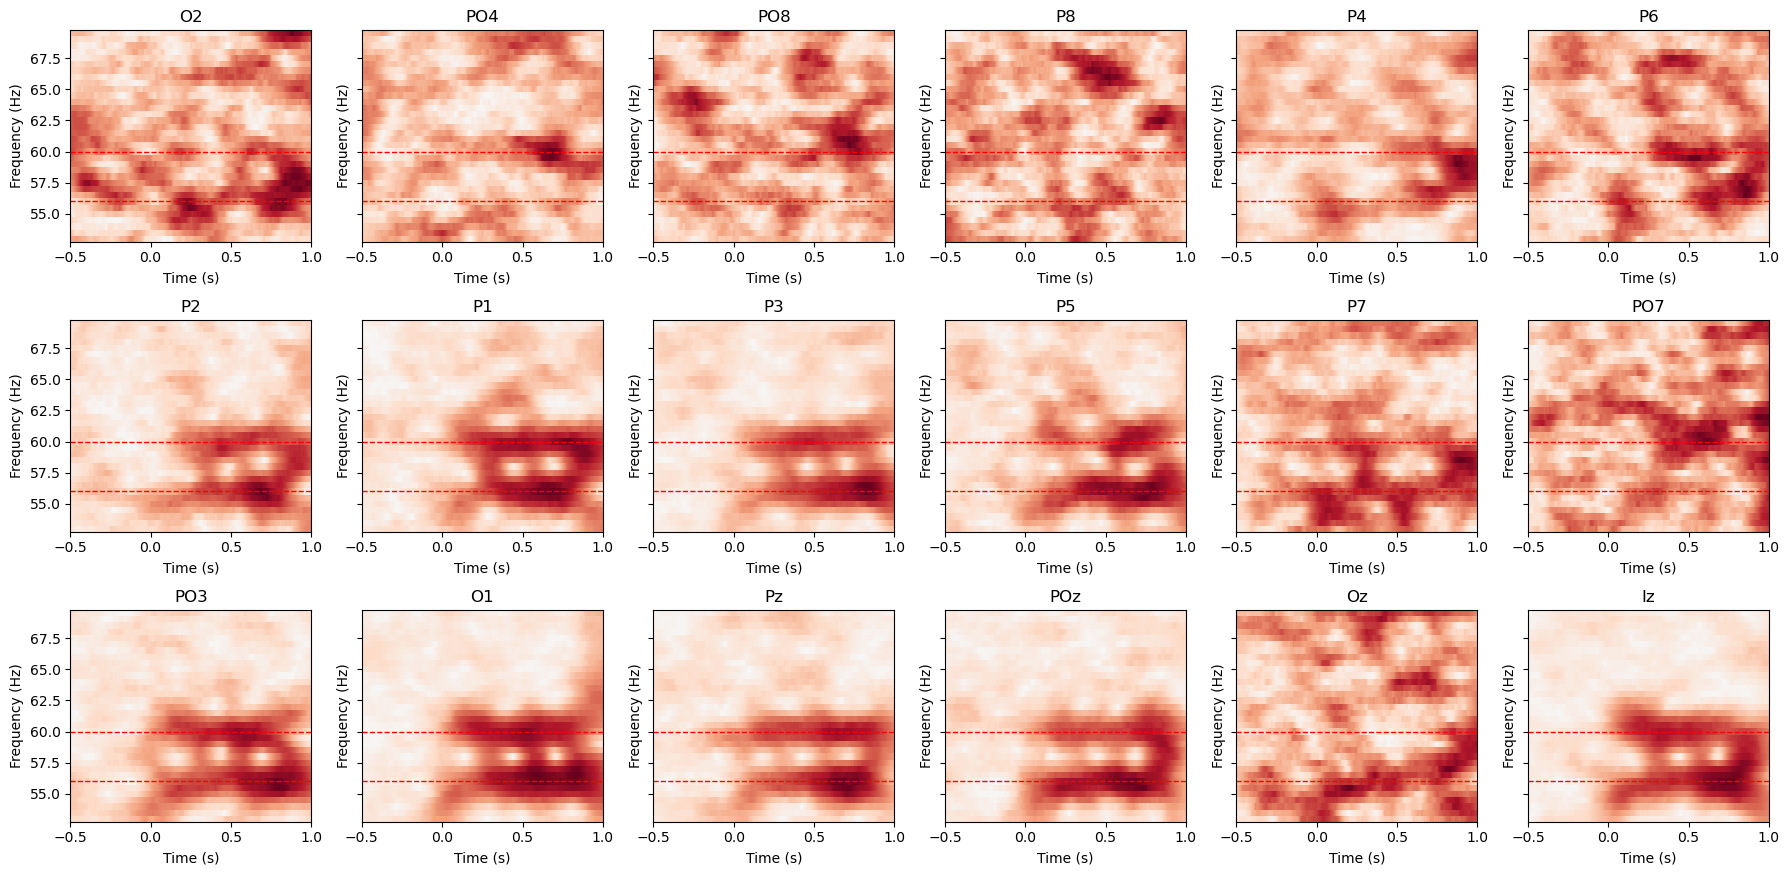

Frequencies with the maximum coherence in descending order : [56.  55.5 56.5 60. ]
From best to 6th 
Channels with the highest coherence with 60:['O1' 'Iz' 'Pz' 'P1' 'P3' 'PO3']                         
Channels with the highest coherence with 56:['O1' 'Iz' 'P3' 'Pz' 'POz' 'PO3']


In [9]:
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized by picking the maximum number of cycles to have the wavelets slightly shorter than the signal.

# time window from -.5 sec to 1 sec relative to cue
tmin, tmax = -.5, 1
# Define range of frequencies of interest
freqs = np.arange(53, 70, step = 0.5)

_, itc = epochs_freqtag.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs-10, return_itc=True, average=True
)

fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
axes = axes.flatten() 

channels = relevant_electrodes#Just plot in relevant electrodes to make it easier

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    itc.plot(
        picks=[channel],
        baseline=None,
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=56, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

# Check whether the expected frequencies are indeed the highest
itc_arr, frex_idx = itc.get_data(return_freqs=True)
print(f'Frequencies with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')

print(f'From best to 6th \nChannels with the highest coherence with 60:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 56:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==56),:].max(axis = -1)))[::-1]][:6]}')

best_electrodes_coherence_morlet_56 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==56),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_morlet_60 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]

## 4 Select electrodes based on previous analysis

In [10]:
print(f'Top 6 electrodes for SNR 56{SNR_best_electrodes_56}')
print(f'Top 6 electrodes for SNR 60{SNR_best_electrodes_60}')
print(f'Top 6 electrodes for ITC Morlet 56 {best_electrodes_coherence_morlet_56}')
print(f'Top 6 electrodes for ITC Morlet 60 {best_electrodes_coherence_morlet_60}')

Top 6 electrodes for SNR 56['O1' 'PO3' 'P5' 'POz']
Top 6 electrodes for SNR 60['Iz' 'O1' 'Pz' 'P6']
Top 6 electrodes for ITC Morlet 56 ['O1' 'Iz' 'P3' 'Pz' 'POz' 'PO3']
Top 6 electrodes for ITC Morlet 60 ['O1' 'Iz' 'Pz' 'P1' 'P3' 'PO3']


In [11]:
# Select top 3 electrodes that are the most often the best according to SNR and IT coherence
# First for 60Hz, then 56Hz
all_electrodes_60 = (list(SNR_best_electrodes_60) + 
                  list(best_electrodes_coherence_morlet_60))

# Count the occurrences of each electrode
electrode_counts = Counter(all_electrodes_60)

best_electrodes_60 = [electrode for electrode, count in electrode_counts.most_common(3)]

all_electrodes_56 = (list(SNR_best_electrodes_56) + 
                  list(best_electrodes_coherence_morlet_56))

# Count the occurrences of each electrode
electrode_counts = Counter(all_electrodes_56)

best_electrodes_56 = [electrode for electrode, count in electrode_counts.most_common(3)]

print(f'selected electrodes for 60Hz: {best_electrodes_60}')
print(f'selected electrodes for 56Hz: {best_electrodes_56}')

best_electrodes = list(set(best_electrodes_60+best_electrodes_56))

# Remove all other electrodes
epochs_freqtag = epochs_freqtag.pick(best_electrodes)

# Store index for correct selection across 60 and 56
best_electrodes_60_idx = np.isin(epochs_freqtag.info['ch_names'], best_electrodes_60)
best_electrodes_56_idx = np.isin(epochs_freqtag.info['ch_names'], best_electrodes_56)


selected electrodes for 60Hz: ['Iz', 'O1', 'Pz']
selected electrodes for 56Hz: ['O1', 'PO3', 'POz']


# Testing for an attentional effect
### Comparing PSD across cued conditions pre stimulus onset

In [12]:
queries = ["cued_tag == 56", "cued_tag == 60"]
vals = {}

tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 1

for query in queries:
    # Spectrum averaged over all trials for all best electrodes
    freqs, amplitudes = ssvep_amplitudes(epochs_freqtag[query], best_electrodes, tmin, tmax)

    # Transform to SNR
    snrs = snr_spectrum(amplitudes, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_60 = np.argmin(abs(freqs - 60))
    i_bin_56 = np.argmin(abs(freqs - 56))

    # Apply the subset, select the electrodes for 60Hz and 56, average over electrodes
    vals[str(60)+query] = copy.deepcopy(np.mean(snrs[best_electrodes_60_idx, i_bin_60], axis=0))
    vals[str(56)+query] = copy.deepcopy(np.mean(snrs[best_electrodes_56_idx, i_bin_56], axis=0))

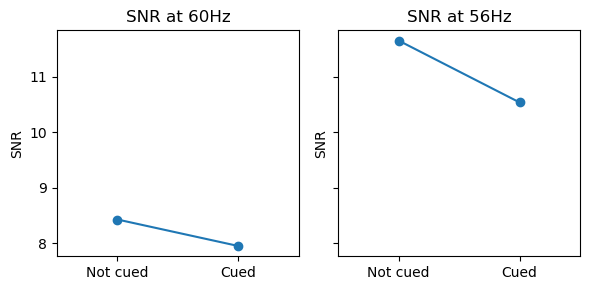

In [13]:
fig, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
ax[0].plot([0,1], [vals['60cued_tag == 56'], vals['60cued_tag == 60']], 'o-')
ax[1].plot([0,1], [vals['56cued_tag == 60'], vals['56cued_tag == 56']], 'o-')

ax[0].set_title('SNR at 60Hz')
ax[1].set_title('SNR at 56Hz')
ax[0].set_ylabel('SNR')
ax[1].set_ylabel('SNR')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_xlim(-.5, 1.5)
plt.tight_layout()
plt.show()

In [14]:
def ami(unattended, attended):
    return (attended-unattended)/(attended+unattended)
    
cueing_60 = ami(vals['60cued_tag == 56'], vals['60cued_tag == 60'])
cueing_56 = ami(vals['56cued_tag == 60'], vals['56cued_tag == 56'])

ami_all = np.stack([cueing_60,cueing_56])
np.save('files/A2_ami.npy', ami_all)